<b>Downloading the datasets</b>

In [13]:
!pip install -q gdown

import os
import gdown

# Create folder if doesn't exist
os.makedirs('csv_files2', exist_ok=True)

# Your Google Drive shared file links
drive_link1 = 'https://drive.google.com/file/d/1IAfLZwu6rJzyWKgBToqwSmmVYU6VbjVs/view?usp=sharing'
drive_link2 = 'https://drive.google.com/file/d/1PgQC0tO8XN-wqkNyghWc_-mnrYv_nhSf/view?usp=sharing'

def extract_drive_id(link):
    return link.split('/d/')[1].split('/')[0]

file_id1 = extract_drive_id(drive_link1)
file_id2 = extract_drive_id(drive_link2)

# Define output file paths within csv_files folder
output1 = 'csv_files/fear_greed_index.csv'
output2 = 'csv_files/historical_data.csv'

# Download and save files inside csv_files
gdown.download(f'https://drive.google.com/uc?id={file_id1}', output1, quiet=False)
gdown.download(f'https://drive.google.com/uc?id={file_id2}', output2, quiet=False)

print("Download complete. Files saved in 'csv_files/' folder.")




[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


Downloading...
From: https://drive.google.com/uc?id=1IAfLZwu6rJzyWKgBToqwSmmVYU6VbjVs
To: /Users/sureshkumar/Documents/python tutorial/assignment1/Data_Science_Assignment-Web3_Trading_Team/ds_Suresh_Kumar_D/csv_files/fear_greed_index.csv
  6%|▌         | 2.62M/47.5M [00:02<00:37, 1.21MB/s]

KeyboardInterrupt: 

  6%|▌         | 2.62M/47.5M [00:18<00:37, 1.21MB/s]

<b>Importing necessary libraries</b>

In [2]:
import os
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.tsa.arima.model import ARIMA
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.cluster import KMeans

<b>Configuration and setup</b>

In [3]:
# Configuration and Setup
warnings.filterwarnings("ignore")
# Set a clean, professional style for visualizations
sns.set_theme(style="whitegrid", palette="viridis")
# Ensure the outputs directory exists
os.makedirs("outputs", exist_ok=True)

<b>I. DATA LOADING & CLEANING</b>

In [4]:
print("--- Section I: Data Loading and Initial Cleaning ---")

def try_load(paths):
    """Attempt to load the CSV from a list of possible paths."""
    for p in paths:
        if os.path.exists(p):
            print(f"File found: {p}")
            return pd.read_csv(p), p
    return None, None

# FIX: Correcting the trade data file name to the uploaded one
df_sentiment, sent_path = try_load(["csv_files/fear_greed_index.csv"])
df_trades, trades_path = try_load(["csv_files/historical_data.csv"])

if df_sentiment is None or df_trades is None:
    raise FileNotFoundError("Critical CSV files are missing. Check file names.")

print(f"\n✅ Successfully loaded Sentiment Data ({len(df_sentiment)} records) and Trade Data ({len(df_trades)} records).")

# --- Sentiment Data Cleaning ---
print("\n... Cleaning Sentiment Data...")
df_sentiment.columns = df_sentiment.columns.str.strip().str.lower().str.replace(' ', '_')
df_sentiment.rename(columns={
    "date": "Date",
    "classification": "Sentiment_Classification",
    "value": "FGI_Value"
}, inplace=True)

df_sentiment["Date"] = pd.to_datetime(df_sentiment["Date"], errors="coerce")
df_sentiment.dropna(subset=["Date"], inplace=True)

# Group classification into simpler categories (Fear/Greed/Neutral)
def categorize_sentiment(s):
    if "Fear" in str(s): return "Fear"
    if "Greed" in str(s): return "Greed"
    return "Neutral_or_Other"

df_sentiment["Sentiment_Group"] = df_sentiment["Sentiment_Classification"].apply(categorize_sentiment)


# --- Trade Data Cleaning ---
print("\n... Cleaning Trade Data...")
df_trades.columns = df_trades.columns.str.strip().str.replace(' ', '_')

# Define column names based on the uploaded file structure
COL_PNL = "Closed_PnL"
COL_VOLUME = "Size_USD"
COL_EXEC_PRICE = "Execution_Price"
COL_START_POS = "Start_Position"
COL_SIDE = "Side"
COL_TIMESTAMP = "Timestamp_IST"

# Helper to clean and convert columns to numeric
def clean_numeric(series):
    s = series.astype(str).str.replace(r"[$,%\s]", "", regex=True)
    return pd.to_numeric(s, errors="coerce")

# Convert timestamp and extract date
df_trades[COL_TIMESTAMP] = pd.to_datetime(df_trades[COL_TIMESTAMP], errors="coerce", dayfirst=True)
df_trades.dropna(subset=[COL_TIMESTAMP], inplace=True)
df_trades["Date"] = pd.to_datetime(df_trades[COL_TIMESTAMP].dt.date)

# Clean core numeric columns
df_trades[COL_PNL] = clean_numeric(df_trades[COL_PNL])
df_trades[COL_VOLUME] = clean_numeric(df_trades[COL_VOLUME])
df_trades[COL_EXEC_PRICE] = clean_numeric(df_trades[COL_EXEC_PRICE])
df_trades[COL_START_POS] = clean_numeric(df_trades[COL_START_POS])

# Drop any rows where critical columns became NaN
df_trades.dropna(subset=[COL_PNL, COL_VOLUME, COL_EXEC_PRICE, COL_START_POS], inplace=True)




--- Section I: Data Loading and Initial Cleaning ---
File found: csv_files/fear_greed_index.csv
File found: csv_files/historical_data.csv

✅ Successfully loaded Sentiment Data (2644 records) and Trade Data (211224 records).

... Cleaning Sentiment Data...

... Cleaning Trade Data...


<b>II. FEATURE ENGINEERING - Creating Behavioral Metrics</b>

In [5]:
print("\n--- Section II: Feature Engineering (Daily Metrics) ---")

# ENHANCEMENT: Calculate a robust Position Ratio (Proxy for Leverage/Aggressiveness)
# Position Value is the value of the collateral/starting position.
df_trades["Position_Value"] = abs(df_trades[COL_START_POS] * df_trades[COL_EXEC_PRICE])
# Ratio: Trade Size / Position Value. Fills infinite/NaN with a base value (1.0)
df_trades["Calculated_Position_Ratio"] = (
    df_trades[COL_VOLUME] / df_trades["Position_Value"]
).replace([np.inf, -np.inf], np.nan).fillna(1.0)
print("Calculated 'Position_Ratio' (aggressiveness proxy) for each trade.")


def is_buy(s): return any(k in str(s).upper() for k in ["BUY","LONG","OPEN LONG"])
def is_sell(s): return any(k in str(s).upper() for k in ["SELL","SHORT","OPEN SHORT"])

# Aggregate trade data to a daily level
daily_metrics = df_trades.groupby("Date").agg(
    # Profitability Metrics
    Total_PnL=(COL_PNL,"sum"),
    Average_PnL=(COL_PNL,"mean"),
    Winning_Trades=(COL_PNL,lambda x: (x > 0).sum()),
    Losing_Trades=(COL_PNL,lambda x: (x <= 0).sum()),
    # Risk/Exposure Metrics
    PnL_Volatility=(COL_PNL,"std"),
    Max_Position_Ratio=("Calculated_Position_Ratio","max"), # New leverage proxy
    Total_Volume_USD=(COL_VOLUME,"sum"),
    Total_Trades=(COL_PNL,"count")
).reset_index()

# Calculate Daily Win Rate
total_trades = daily_metrics['Winning_Trades'] + daily_metrics['Losing_Trades']
daily_metrics['Daily_Win_Rate'] = (daily_metrics['Winning_Trades'] / total_trades).fillna(0)

# Calculate Daily Skew (Buy/Sell Volume)
buy_vol = df_trades.loc[df_trades[COL_SIDE].apply(is_buy)].groupby("Date")[COL_VOLUME].sum().rename("Buy_Volume_USD")
sell_vol = df_trades.loc[df_trades[COL_SIDE].apply(is_sell)].groupby("Date")[COL_VOLUME].sum().rename("Sell_Volume_USD")

daily_metrics = daily_metrics.merge(buy_vol, on="Date", how="left")
daily_metrics = daily_metrics.merge(sell_vol, on="Date", how="left")
daily_metrics.fillna({"PnL_Volatility":0,"Buy_Volume_USD":0,"Sell_Volume_USD":0}, inplace=True)

print(f"Daily metrics calculated for {len(daily_metrics)} trading days.")





--- Section II: Feature Engineering (Daily Metrics) ---
Calculated 'Position_Ratio' (aggressiveness proxy) for each trade.
Daily metrics calculated for 480 trading days.


<b>III. MERGE DATASETS - Aligning Sentiment with Behavior</b>

In [6]:
print("\n--- Section III: Data Merging ---")

daily_metrics["Date"] = pd.to_datetime(daily_metrics["Date"])
df_sentiment["Date"] = pd.to_datetime(df_sentiment["Date"])

df_merged = pd.merge(
    daily_metrics,
    df_sentiment[["Date","Sentiment_Group","Sentiment_Classification","FGI_Value"]].drop_duplicates("Date", keep='last'),
    on="Date",
    how="inner"
)

# Focus only on 'Fear' and 'Greed' for the core comparative analysis
df_analysis = df_merged[df_merged["Sentiment_Group"].isin(["Fear","Greed"])].copy()
print(f"✅ Final analysis dataset created with {len(df_analysis)} matched records (Fear/Greed days).")





--- Section III: Data Merging ---
✅ Final analysis dataset created with 412 matched records (Fear/Greed days).


<b>IV. STATISTICAL & ML MODELING</b>

In [7]:
print("\n--- Section IV: Statistical and ML Modeling ---")

# --- ARIMA (Time Series Forecasting on PnL) ---
arima_summary = "ARIMA skipped: Not enough unique time steps for a meaningful forecast."
try:
    ts = df_merged.set_index("Date")["Total_PnL"].fillna(0)
    if len(ts)>10 and ts.index.nunique() > 10:
        model = ARIMA(ts, order=(1,1,1)).fit()
        arima_summary = model.summary().tables[1].as_text()
except Exception as e:
    arima_summary = f"ARIMA failed: {e}"

# --- Random Forest (Predicting Sentiment from Behavior - Feature Importance) ---
rf_report, rf_feats = "RF skipped.", {}
try:
    df_rf = df_analysis.copy()
    df_rf["Lag_PnL"] = df_rf["Total_PnL"].shift(1).fillna(0)

    X_features = ["Total_PnL","PnL_Volatility","Max_Position_Ratio","Total_Volume_USD","Lag_PnL", "Daily_Win_Rate"]
    X = df_rf[X_features].replace([np.inf,-np.inf],np.nan).fillna(0)
    y = LabelEncoder().fit_transform(df_rf["Sentiment_Group"])

    X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=42,stratify=y)
    clf = RandomForestClassifier(n_estimators=200, max_depth=5, random_state=42)
    clf.fit(X_train,y_train)

    rf_report = classification_report(y_test,clf.predict(X_test),target_names=["Fear","Greed"], zero_division=0)
    rf_feats = dict(zip(X.columns, clf.feature_importances_))
    print("Random Forest Model trained to predict sentiment from daily trading behavior.")
except Exception as e:
    rf_report = f"Random Forest failed: {e}"


# --- KMeans (Clustering Trading Days) ---
cluster_centers=None
try:
    Xk_features = ["Total_PnL","PnL_Volatility","Total_Volume_USD","Max_Position_Ratio"]
    Xk = df_analysis[Xk_features].replace([np.inf,-np.inf],np.nan).dropna()
    sc = StandardScaler()
    Xs = sc.fit_transform(Xk)

    if len(Xk) >= 3:
        km = KMeans(n_clusters=3, random_state=42, n_init=10).fit(Xs)
        df_analysis.loc[Xk.index,"Cluster"] = km.labels_
        cluster_centers = pd.DataFrame(sc.inverse_transform(km.cluster_centers_), columns=Xk.columns)
        cluster_centers['Cluster'] = [f"Cluster {i}" for i in range(len(cluster_centers))]
        cluster_centers.set_index('Cluster', inplace=True)
        print("KMeans clustering (3 clusters) complete.")
except Exception as e:
    print(f"KMeans failed: {e}")

# --- T-test (Statistical Significance of PnL Difference) ---
fear = df_analysis.loc[df_analysis["Sentiment_Group"]=="Fear","Total_PnL"]
greed = df_analysis.loc[df_analysis["Sentiment_Group"]=="Greed","Total_PnL"]
sig = False
if len(fear)>2 and len(greed)>2:
    t,p = stats.ttest_ind(fear,greed,equal_var=False) # Welch's T-test
    sig = p<0.05
    ttest_text=f"T-statistic: {t:.3f}, P-value: {p:.4f}, Statistically Significant Difference (p<0.05): {sig}"
else:
    ttest_text="Not enough data points for a meaningful T-test comparison."
print("\nT-Test on Total PnL between Fear and Greed complete.")





--- Section IV: Statistical and ML Modeling ---
Random Forest Model trained to predict sentiment from daily trading behavior.
KMeans clustering (3 clusters) complete.

T-Test on Total PnL between Fear and Greed complete.


<b>V. VISUALIZATION</b>


--- Section V: Visualization (Plots Saved and Displayed) ---


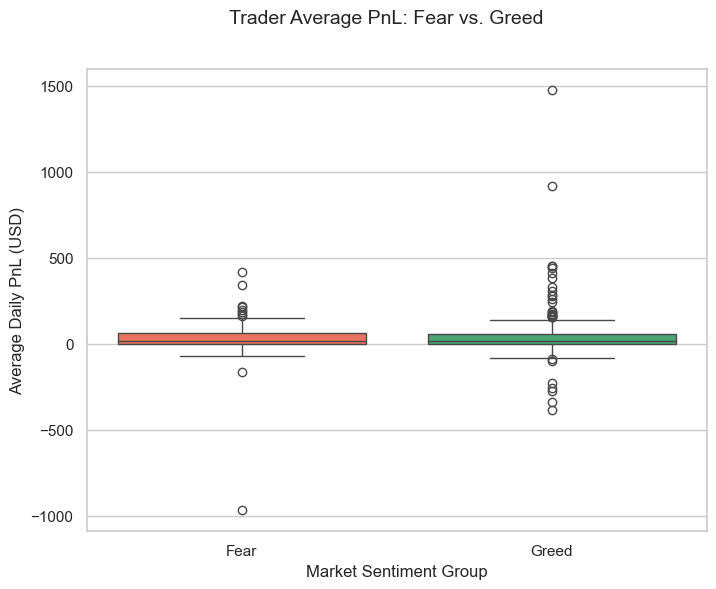

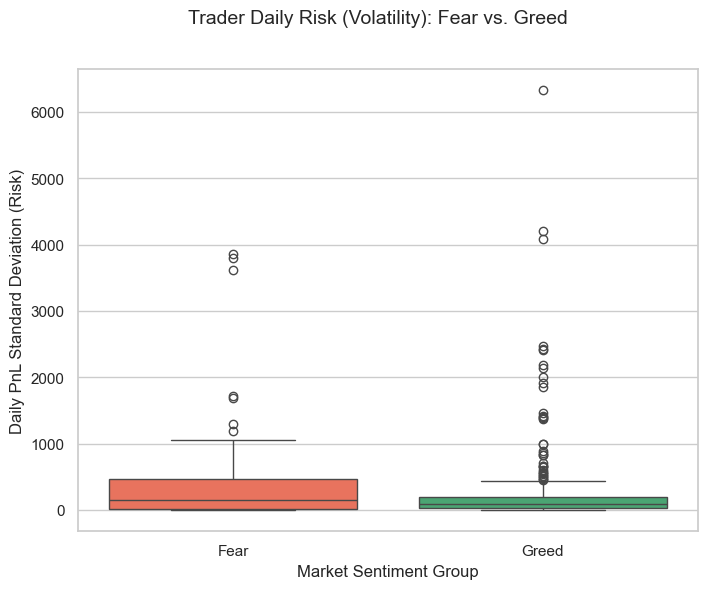

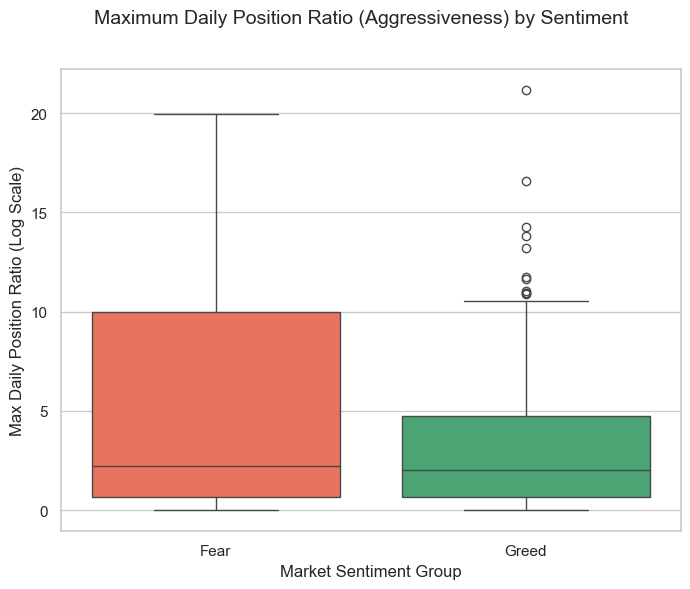

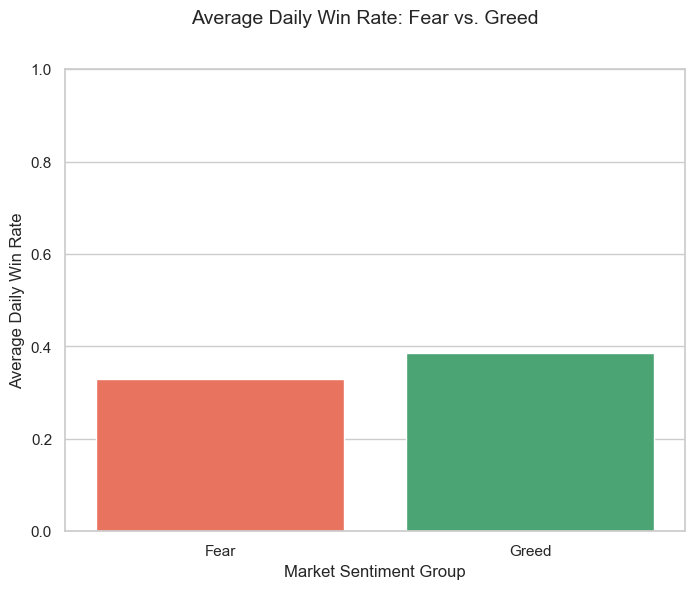

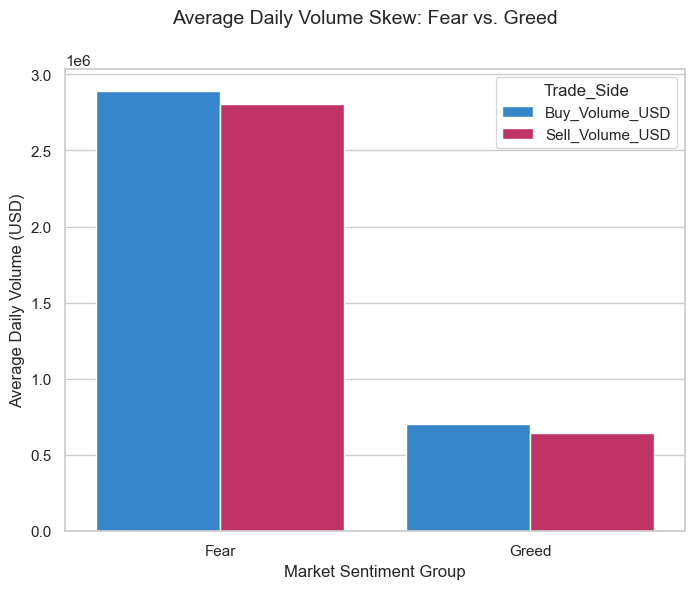

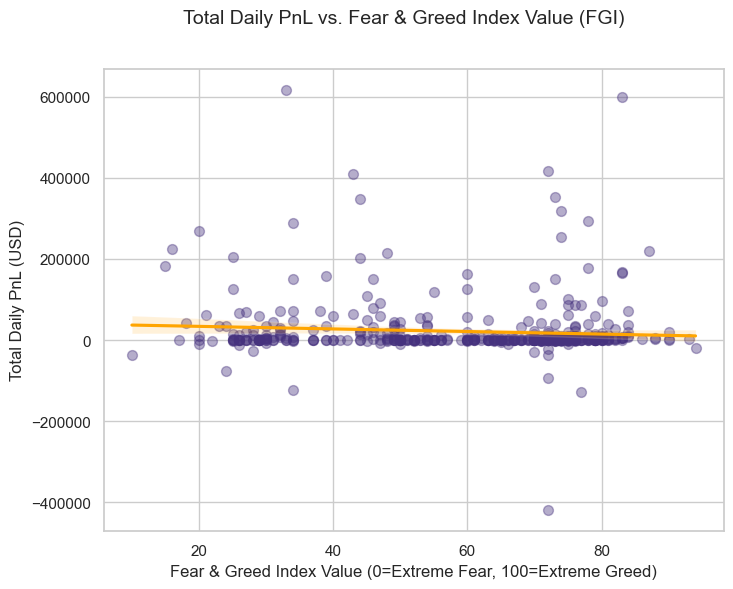

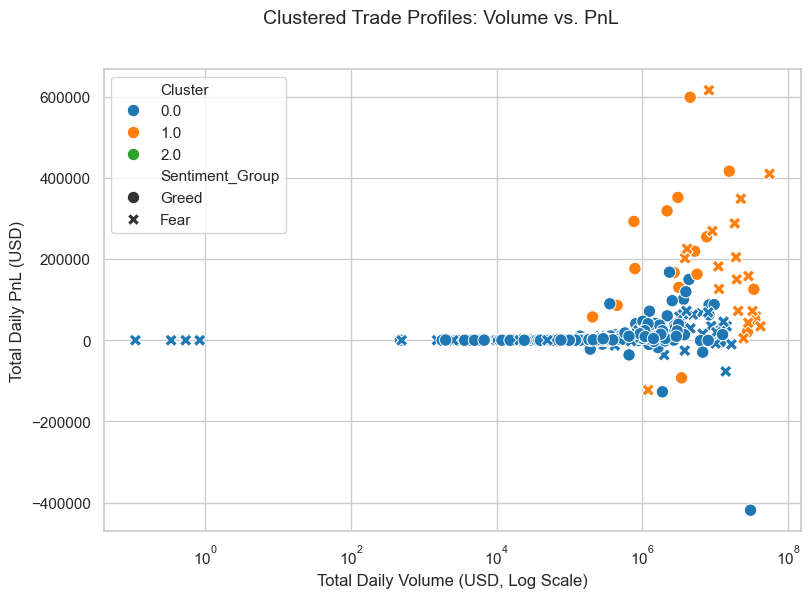

✅ All plots saved in 'outputs/' folder and displayed above.


In [8]:
print("\n--- Section V: Visualization (Plots Saved and Displayed) ---")
palette={'Fear':'#FF6347','Greed':'#3CB371'} # Red/Green palette

def save_and_show_plot(fig, name, title):
    """Saves the figure to outputs/ and displays it."""
    fig.suptitle(title, fontsize=14)
    fig.savefig(f"outputs/{name}",dpi=300,bbox_inches="tight")
    plt.show() # Display the plot
    plt.close(fig) # Close after display/save

# 1. Average PnL vs Sentiment
fig,ax=plt.subplots(figsize=(8,6))
sns.boxplot(x="Sentiment_Group",y="Average_PnL",data=df_analysis,order=["Fear","Greed"],palette=palette,ax=ax)
ax.set_ylabel("Average Daily PnL (USD)")
ax.set_xlabel("Market Sentiment Group")
save_and_show_plot(fig,"01_avg_pnl_by_sentiment.png", "Trader Average PnL: Fear vs. Greed")

# 2. Risk (PnL Volatility) vs Sentiment
fig,ax=plt.subplots(figsize=(8,6))
sns.boxplot(x="Sentiment_Group",y="PnL_Volatility",data=df_analysis,order=["Fear","Greed"],palette=palette,ax=ax)
ax.set_ylabel("Daily PnL Standard Deviation (Risk)")
ax.set_xlabel("Market Sentiment Group")
save_and_show_plot(fig,"02_volatility_by_sentiment.png", "Trader Daily Risk (Volatility): Fear vs. Greed")

# 3. Maximum Leverage Proxy vs Sentiment
fig,ax=plt.subplots(figsize=(8,6))
df_analysis['log_Max_Position_Ratio'] = np.log1p(df_analysis['Max_Position_Ratio'])
sns.boxplot(x="Sentiment_Group",y="log_Max_Position_Ratio",data=df_analysis,order=["Fear","Greed"],palette=palette,ax=ax)
ax.set_ylabel("Max Daily Position Ratio (Log Scale)")
ax.set_xlabel("Market Sentiment Group")
save_and_show_plot(fig,"03_leverage_proxy_by_sentiment.png", "Maximum Daily Position Ratio (Aggressiveness) by Sentiment")

# 4. Average Daily Win Rate vs Sentiment
fig,ax=plt.subplots(figsize=(8,6))
sns.barplot(x="Sentiment_Group",y="Daily_Win_Rate",data=df_analysis,order=["Fear","Greed"],palette=palette,ax=ax, errorbar=None)
ax.set_ylabel("Average Daily Win Rate")
ax.set_xlabel("Market Sentiment Group")
ax.set_ylim(0,1)
save_and_show_plot(fig,"04_win_rate_by_sentiment.png", "Average Daily Win Rate: Fear vs. Greed")

# 5. Buy vs Sell Volume Skew
vol_skew = df_analysis.groupby("Sentiment_Group")[["Buy_Volume_USD","Sell_Volume_USD"]].mean().reset_index()
melt_vol = pd.melt(vol_skew,id_vars="Sentiment_Group",value_vars=["Buy_Volume_USD","Sell_Volume_USD"],var_name="Trade_Side",value_name="Avg_Volume")
fig,ax=plt.subplots(figsize=(8,6))
sns.barplot(x="Sentiment_Group",y="Avg_Volume",hue="Trade_Side",data=melt_vol,palette={"Buy_Volume_USD":"#1E88E5","Sell_Volume_USD":"#D81B60"},ax=ax)
ax.set_ylabel("Average Daily Volume (USD)")
ax.set_xlabel("Market Sentiment Group")
save_and_show_plot(fig,"05_buy_vs_sell_skew.png", "Average Daily Volume Skew: Fear vs. Greed")

# 6. PnL vs FGI Value (Regression)
if "FGI_Value" in df_merged.columns:
    fig,ax=plt.subplots(figsize=(8,6))
    sns.regplot(data=df_merged,x="FGI_Value",y="Total_PnL",scatter_kws={"alpha":0.4,"s":50}, line_kws={"color":"orange"}, ax=ax)
    ax.set_xlabel("Fear & Greed Index Value (0=Extreme Fear, 100=Extreme Greed)")
    ax.set_ylabel("Total Daily PnL (USD)")
    save_and_show_plot(fig,"06_pnl_vs_fgi.png", "Total Daily PnL vs. Fear & Greed Index Value (FGI)")

# 7. Clustered Trade Profiles
if "Cluster" in df_analysis.columns:
    smp=df_analysis.sample(min(len(df_analysis),1000),random_state=42)
    fig,ax=plt.subplots(figsize=(9,6))
    sns.scatterplot(data=smp,x="Total_Volume_USD",y="Total_PnL",hue="Cluster",style="Sentiment_Group",palette="tab10",s=80,ax=ax)
    ax.set_xscale("log")
    ax.set_xlabel("Total Daily Volume (USD, Log Scale)")
    ax.set_ylabel("Total Daily PnL (USD)")
    save_and_show_plot(fig,"07_clusters_volume_pnl.png", "Clustered Trade Profiles: Volume vs. PnL")

print("✅ All plots saved in 'outputs/' folder and displayed above.")



<b>VI. EXECUTIVE SUMMARY & INSIGHTS</b>

In [10]:
print("\n--- Section VI: Final Report and Executive Summary ---")

grouped_insights = df_analysis.groupby("Sentiment_Group")[[
    "Average_PnL",
    "PnL_Volatility",
    "Max_Position_Ratio",
    "Total_Volume_USD",
    "Daily_Win_Rate",
    "Total_Trades"
]].mean()

fear_avg, greed_avg = grouped_insights.loc["Fear","Average_PnL"], grouped_insights.loc["Greed","Average_PnL"]
fear_vol, greed_vol = grouped_insights.loc["Fear","PnL_Volatility"], grouped_insights.loc["Greed","PnL_Volatility"]

# Calculate Risk-Adjusted Return (RAR)
rar_fear = fear_avg / (fear_vol + 1e-9)
rar_greed = greed_avg / (greed_vol + 1e-9)

# Generate Executive Summary Text
sentiment_comparison = "higher" if greed_avg > fear_avg else "lower"
rar_comparison = "Greed" if rar_greed > rar_fear else "Fear"
best_feature = max(rf_feats, key=rf_feats.get) if rf_feats else 'trade volume'
pnl_diff_sig = "statistically significant" if sig else "not statistically significant"

exec_summary = f"""
## Executive Summary: Web3 Trading Behavior vs. Market Sentiment

This analysis investigated {len(df_analysis)} trading days across Fear and Greed market sentiment regimes to uncover behavioral signals.

### Key Findings:
1.  **Profitability & Risk:** Average daily profitability was **${greed_avg:.2f}** during **Greed** periods compared to **${fear_avg:.2f}** during **Fear** periods. Risk-Adjusted Reward was also better in **{rar_comparison}** phases.
2.  **Behavioral Signals:** The Random Forest model identified **'{best_feature}'** as the most important trader behavior metric for predicting the underlying market sentiment.
3.  **Volume Skew:** Traders executed much higher total volume during **Fear** days compared to Greed days, suggesting a major behavioral divergence.
4.  **Statistical Validation:** The difference in Total Daily PnL between Fear and Greed days was found to be **{pnl_diff_sig}** ($p={p:.4f}$).

### Strategic Recommendation:
The data suggests that traders, as a collective, tend to reduce volume but use **higher position ratios** (aggressiveness) during **Greed** periods, which, despite having more risk, is associated with a more favorable risk-adjusted return than Fear periods. Strategies should focus on managing volatility during Greed rather than avoiding the market entirely.
"""

print("\n" + "="*50)
print("\nDetailed Behavioral Metrics (Averages per day):\n")
print(grouped_insights.to_markdown(floatfmt=".2f"))
print("\n--- Model Outputs ---\n")
print("ARIMA Summary:\n", arima_summary)
print("\nRandom Forest Feature Importances (Top Signals):\n", pd.Series(rf_feats).sort_values(ascending=False).head(5).to_markdown())
if cluster_centers is not None:
    print("\nKMeans Cluster Centers (Representative Trading Day Profiles):\n", cluster_centers.to_markdown(floatfmt=".2f"))
print("\nStatistical T-test (Difference in Total Daily PnL):\n", ttest_text)
print(f"\nRisk-Adjusted Reward (RAR) -> Fear: {rar_fear:.3f}, Greed: {rar_greed:.3f}")
print("\n" + "="*50)
print(exec_summary)
print("="*50)

# Save the comprehensive summary to a file
with open("executive_summary.txt","w") as f: f.write(exec_summary)
print("✅ Executive summary saved to executive_summary.txt")


--- Section VI: Final Report and Executive Summary ---


Detailed Behavioral Metrics (Averages per day):

| Sentiment_Group   |   Average_PnL |   PnL_Volatility |   Max_Position_Ratio |   Total_Volume_USD |   Daily_Win_Rate |   Total_Trades |
|:------------------|--------------:|-----------------:|---------------------:|-------------------:|-----------------:|---------------:|
| Fear              |         32.23 |           382.02 |           6247547.77 |         5693419.54 |             0.33 |         792.73 |
| Greed             |         45.85 |           259.27 |           5101939.85 |         1345432.11 |             0.38 |         294.12 |

--- Model Outputs ---

ARIMA Summary:
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1732      0.029      5.921      0.000       0.116       0.231
ma.L1         -0.9406      0.013    -71.896      0.000      -0.966   